<a href="https://colab.research.google.com/github/aryamanshodhan/DL-final-project/blob/main/DLFinalProject_DeepLabV3_And_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Final Project

Aryaman Shodhan ashodha1,
Trisha Karani \<JHED\>,
Shreya Wadhwa \<JHED\>,
Aidan Aug \<JHED\>

This Colab Notebook investigates various segmentation models in segmenting the CholecSeg8k semantic segmentation dataset based on Cholec80. The dataset has the following specifications:
1. A subset of Cholec80, where videos captured the procedure at 25 fps and annotated tools presence and operation phases
2. 13 different object (classes) including black background, abdominal wall, liver, gastrointestinal tract, fat, grasper, connective tissue, blood, cystic duct, L hook electrocautery (Instrument), gallbladder, hepatic vein, and liver ligament (see Data Preprocessing for visualization)
3. 3 masks --> 1 color mask, one mask used by annotation tool, and one watershed mask
4. Images are in RGB
5. Directories are such that each contains 80 consecutive frames of the video with a resolution of 854x480 and the annotated semantic segmentation masks


The link to the official dataset can be found here: https://www.kaggle.com/datasets/newslab/cholecseg8k

# Setup: 

Mounting Drive, importing libraries, and determining device

In [1]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
## Standard Library
import os
import json
import re
import random

## External Libraries
import torch
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import time

In [3]:
# GPU Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu = True if torch.cuda.is_available() else False

In [4]:
import random
random.seed(888)
torch.manual_seed(888)
np.random.seed(888)

# Data Preprocessing

MAKE SURE TO UPDATE DATA_DIR FOR THE PATH TO THE DATA!!!

The below code implements the following dataloading and pre-processing steps:
1. Loads in the data from specified repository
2. Splits data into an 80:10:10 train-val-test split
3. Generates an ImageDataset class based on this data for feeding into a dataloader
4. Visualizing data

TODO: INCLUDE THE STEPS PERFORMED FOR PREPROCESSING THE DATA

Eg. Augmentations, split into train val test, etc.

In [5]:
### ENTER BASE DATA DIRECTORY HERE TO PROJECT PATH:
# data_dir = "/content/gdrive/MyDrive/Deep_Learning/" #Aryaman
# data_dir = "/content/gdrive/MyDrive/Notes/Spring 2023/Deep Learning/Deep_Learning/" #Shreya
data_dir = "/content/gdrive/MyDrive/MLDL/Final_Project/Deep_Learning/" # Aidan

mask_json = f"{data_dir}archive/mapping.json"

# Fetch all of the data paths
data = []
for root, _, files in os.walk(data_dir + "archive"):
  files = sorted(filter(lambda x: re.search("(endo.png$)|(watershed_mask.png$)", x) is not None, files))
  for idx in range(len(files)):
    if (idx % 2 == 0):
      data_point = [os.path.join(root, files[idx])]
    else:
      data_point += [os.path.join(root, files[idx])]
      data.append(data_point)

random.shuffle(data)

In [6]:
class ImageDataset(Dataset):
  def __init__(self, data, mask_json, transforms=None):
    self.data = data
    self.mask_json = mask_json
    self.transforms = transforms

    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    return img, mask

In [7]:
## Divide the data
train_range_end = int(0.8 * len(data))
val_range_end = int(0.9 * len(data))
test_range_end = int(1.0 * len(data))

train_datapoints = data[0:train_range_end]
val_datapoints = data[train_range_end:val_range_end]
test_datapoints = data[val_range_end:test_range_end]

In [8]:
# NOTE: Training with the entire dataset was too computationally expensive. 
# We have further divded the data into smaller datasets using the following split:
num_train = 600
num_val = 100
num_test = 100

In [9]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=True), #Ratios must be compatible with UNet
])

############ Generate DataLoaders ###########

train_dataset = ImageDataset(data=train_datapoints, mask_json=mask_json, transforms=img_transforms)
val_dataset = ImageDataset(data=val_datapoints, mask_json=mask_json, transforms=img_transforms)
test_dataset = ImageDataset(data=test_datapoints, mask_json=mask_json, transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(f"Batches of Training Dataloader: {len(train_dataloader)}")
print(f"Batches of Validation Dataloader: {len(validation_dataloader)}")
print(f"Batches of Testing Dataloader: {len(test_dataloader)}")


Batches of Training Dataloader: 20
Batches of Validation Dataloader: 4
Batches of Testing Dataloader: 100


In [10]:
len(train_mask)

600

### Visualize Data

In [11]:
def visualize(dataloader, n_batches=1, n_samples=1):
    for _ in range(n_batches):
        img, mask = next(iter(dataloader))
        
        img = img.numpy().transpose(0, 2, 3, 1)
        mask = mask.numpy().transpose(0, 2, 3, 1)

        for i in range(n_samples): 
            fig, ax = plt.subplots(1, 2, figsize=(9, 3))
            ax[0].imshow(img[i])
            ax[0].set_title("Input Image")    

            ax[1].imshow(np.argmax(mask[i], axis=-1), cmap="gray")
            ax[1].set_title("Ground Truth")

        plt.show()

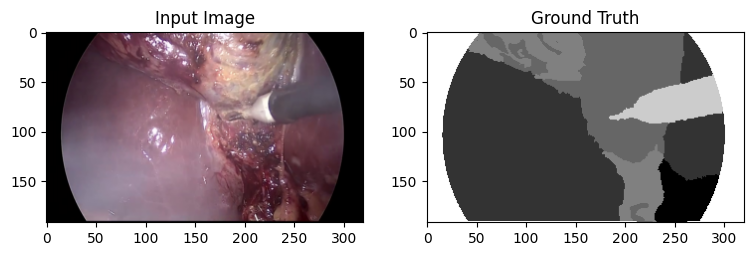

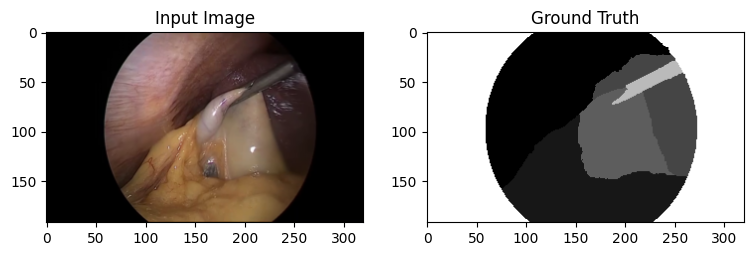

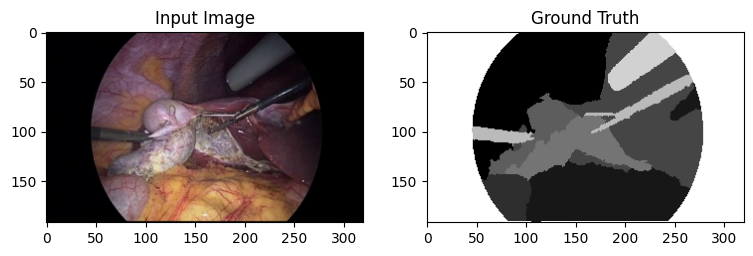

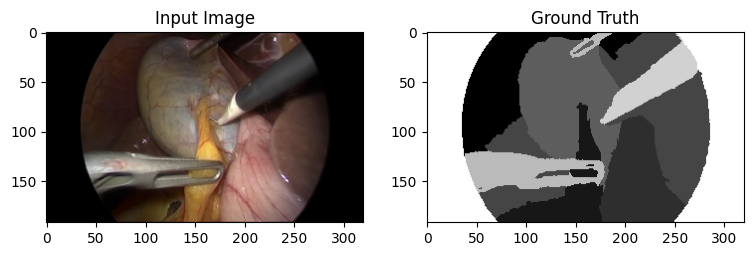

In [12]:
# %%script echo skipping
visualize(train_dataloader, n_samples=4)

# Loss Functions

TODO: INCLUDE DESCRIPTION OF RATIONALE BEHIND DICELOSS AND IOU

Dice Loss

Remember to include references about where we got the equation from!

https://medium.com/analytics-vidhya/different-iou-losses-for-faster-and-accurate-object-detection-3345781e0bf

In [13]:
# IOU Loss = 1 - (|A intersect B| / |A union B|)
class IOULoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(IOULoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks, n_classes):
    batch_size = target_masks.shape[0]
    iou_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      iou_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        iou_classes[cl] = intersection / (predicted_mask[cl].sum() + target_mask[cl].sum() - intersection)
      iou_scores[batch] = iou_classes.mean()
    return 1.0 - iou_scores.mean()

In [14]:
# DICE Loss = 1 - (2 * |A intersect B| / (|A| + |B|))
class DICELoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(DICELoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks):
    n_classes = predicted_masks.shape[1]
    batch_size = target_masks.shape[0]
    dice_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      dice_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        dice_classes[cl] = 2 * intersection / (predicted_mask[cl].sum() + target_mask[cl].sum())
      dice_scores[batch] = dice_classes.mean()
    return 1.0 - dice_scores.mean()

In [15]:
## Loss Functions Testing

# Batch has 1 item with 3 classes
predicted = torch.Tensor([
    # Class 1
    [[[0.2, 0.1, 0.05],
    [0.1, 0.3, 0.4],
    [0.6, 0.75, 0.25]],

    # Class 2
    [[0.25, 0.1, 0.9],
    [0.45, 0.2, 0.3],
    [0.2, 0.15, 0.05]],

    # Class 3
    [[0.55, 0.8, 0.05],
    [0.45, 0.5, 0.3],
    [0.2, 0.1, 0.7]]]
])

# Batch has 1 item with 3 classes
target = torch.Tensor([
    # Class 1
    [[[0, 0, 0],
    [0, 0, 1],
    [1, 0, 0]],

    # Class 2
    [[1, 0, 1],
    [0, 1, 0],
    [0, 1, 0]],

    # Class 3
    [[0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]]]
])

# IOU Score for Class 1: 1.0 / (2.0 + 2.75 - 1.0) = 0.2667
# IOU Score for Class 2: 1.5 / (4.0 + 2.6 - 1.5) = 0.2941
# IOU Score for Class 3: 1.95 / (3.0 + 3.65 - 1.95) = 0.4149
# Mean IOU Score: 0.3252
# Loss = 1 - 0.3252 = 0.6748
iou = IOULoss()
iou_loss = iou.forward(predicted, target, n_classes=3).item()
assert(iou_loss == 0.6747740507125854)

# DICE Score for Class 1: 2 * 1.0 / (2.0 + 2.75) = 0.4211
# DICE Score for Class 2: 2 * 1.5 / (4.0 + 2.6) = 0.4545
# DICE Score for Class 3: 2 * 1.95 / (3.0 + 3.65) = 0.5865
# Mean DICE Score: 0.4874
# Loss = 1 - 0.4874 = 0.5126
dice = DICELoss()
# dice_loss = dice.forward(predicted, target, n_classes=3).item()
dice_loss = dice.forward(predicted, target).item()

assert(dice_loss == 0.5126452445983887)

In [16]:
def dice_score_image(prediction, target, n_classes):
    dice_classes = np.zeros(n_classes)
    # target = target.reshape(n_classes, -1)
    # prediction = prediction.reshape(n_classes, -1)
    for cl in range(n_classes):
      target_cl = target[:, cl, :, :]
      prediction_cl = prediction[:, cl, :, :]

      TP = (prediction_cl * target_cl).sum().item()
      FP = ((1 - target_cl) * prediction_cl).sum().item()
      FN = (target_cl * (1 - prediction_cl)).sum().item()

      #When there is no grount truth of the class in this image
      #Give 1 dice score if False Positive pixel number is 0, 
      #give 0 dice score if False Positive pixel number is not 0 (> 0).
      if target_cl.sum() == 0 and FP == 0:
          dice_classes[cl] = 1.0
      elif target_cl.sum() == 0 and FP > 0:
          dice_classes[cl] = 0.0
      else:
        dice_classes[cl] = 2 * TP / (2 * TP + FP + FN)
    return dice_classes.mean()


def dice_score_dataset(model, dataloader, use_gpu=False, is_deep_lab=False):
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)

    model.eval()
    idx = 0
    for data in dataloader:

        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()

        out = model(img)
        if (is_deep_lab):
          out = out['out']
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        prediction = nn.functional.one_hot(prediction, n_classes)
        prediction = prediction.permute(0, 3, 1, 2)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1

    m_dice = scores.mean()
    return m_dice

# Training and Validation

In [17]:
def test_eval(test_dataloader, model, loss, verbose = 1, is_deep_lab=False):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deep_lab:
            outputs = outputs['out'] # Only for DeepLabV3
          if i <= 5:
            fig, ax = plt.subplots(1, 3)
            img = outputs[0]
            img = np.argmax(img.cpu().numpy(), axis=0)
            ax[0].imshow(img, cmap="gray")
            ax[0].set_title("Predicted")    

            ax[1].imshow(np.argmax(labels[0].cpu().numpy(), axis=0), cmap="gray")
            ax[1].set_title("Labels")

            input = images[0].permute(1, 2, 0).cpu().numpy()
            ax[2].imshow(input)
            ax[2].set_title("Input")

            plt.show()
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [18]:
def val_eval(val_dataloader, model, loss, verbose = 0, is_deep_lab=False):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in val_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deep_lab:
            outputs = outputs['out'] # Only for DeepLabV3
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Val loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [19]:
def train(model, train_data_loader, validation_dataloader, optimizer, loss, num_epochs, is_deep_lab=False):

  loss_fail = 0
  patience = 5
  best_model = model
  best_val_loss = float('inf')
  n_classes = 13
  print("Start Training...")
  print("{:<10} {:<20} {:<20} {:<15} {:<15} {:<15}".format('epoch', 'train loss','val loss', 'es_counter(/5)', 'min-val-loss', 'time(s)'))
  time_start = time.time() #timekeeping
  for epoch in range(num_epochs):
      ########################### Training #####################################
      # TODO: Design your own training section
      time_epoch_start = time.time() #timekeeping
      loss_sum = 0
      correct = 0
      total = 0
      for i, data in enumerate(train_dataloader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
          
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
        if is_deep_lab:
          outputs = outputs['out'] #only for DeepLabV3

        loss_val = loss(outputs, y)
        loss_val.backward()
        optimizer.step()

        # train eval
        loss_sum += loss_val.item()
        total += y.size(0)

      train_loss = loss_sum / total

      ########################### Validation #####################################
      # TODO: Design your own validation section
      val_loss = val_eval(validation_dataloader, model, loss, is_deep_lab=is_deep_lab)

      # Early Stopping
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        loss_fail = 0
      else:
        loss_fail += 1
      
      if loss_fail == patience:
          print("Stopping Early..")
          print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n", "Train Loss:",train_loss, "Validation Loss:",val_loss)
          break

      time_epoch_end = time.time()
      total_time = time_epoch_end - time_start

      if epoch % 2 == 0:
          print("{:<10} {:<20f} {:<20f} {:<15d} {:<15f} {:<15f}".format(
            epoch, train_loss, val_loss, loss_fail, round(best_val_loss,10), total_time))
      if epoch == 0:
          L = train_loss
          A = val_loss
      else:
          L = np.append(L,train_loss)
          A = np.append(A,val_loss)

  ## Plot Training Loss and Validation Loss
  plt.plot(L,'-', label='Training Loss')
  plt.plot(A,'-', label='Validation Loss')
  plt.xlabel('Iteration', fontsize=18)
  plt.ylabel('Loss', fontsize=16)
  plt.legend(loc='best')
  plt.show()

  return best_model

# EXPERIMENT 1 Comparing 2-3 different segmentation models

## UNET

### Restart Runtime

In [20]:
torch.cuda.empty_cache()

### Define Model

In [21]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations

        # Last layer of UNet is 1x1 convolution with 1 filter of size 1x1
        self.final_layer = nn.Conv2d(32, n_classes, kernel_size=1)

        # Will use softmax since n_classes is provided as a parameters, 
        # but this is a two class classification problem (i.e., only need sigmoid)
        self.final_activation = nn.Sigmoid()


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        softmax_probs = self.final_layer(conv1m_out)
        output = self.final_activation(softmax_probs)
        
        return output


### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)  min-val-loss    time(s)        
0          0.077871             0.090354             0               0.090354        97.366518      
2          0.071127             0.083888             0               0.083888        278.907742     
4          0.067058             0.079366             0               0.079366        459.505824     
6          0.064295             0.076280             0               0.076280        641.476067     
8          0.062499             0.074296             0               0.074296        822.370437     
10         0.060880             0.072776             0               0.072776        1002.576179    
12         0.059918             0.072097             0               0.072097        1181.726093    
14         0.059201             0.070983             0               0.070983        1367.786618    
16         0.058775             0.070336             0               0.07

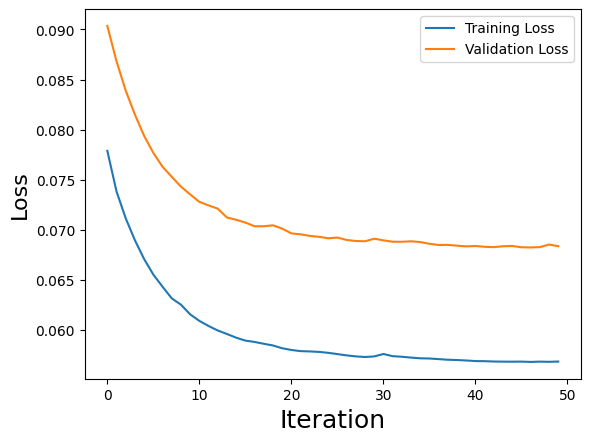

In [22]:
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50 #Change to 200 later

## Setting up the model, optimizer, and loss function
n_classes = 13
model = UNET(n_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_trained = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs)

In [ ]:
dice_score_dataset(unet_trained, test_dataloader, n_classes)

0.6844429287206578

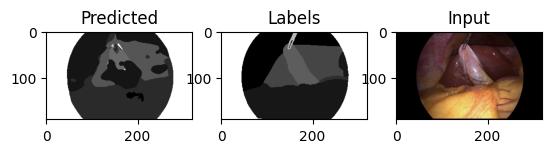

Test loss: 2.088775


2.0887748060876277

In [ ]:
test_eval(test_dataloader, unet_trained, loss)

In [ ]:
torch.save(unet_trained, "/content/gdrive/MyDrive/MLDL/Final_Project/Deep_Learning/saved_models/models/unet_trained_rand_seed.pt")

## DeepLabV3

### Restart Runtime

In [ ]:
torch.cuda.empty_cache()

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)  min-val-loss    time(s)        
0          0.315969             13.524937            0               13.524937       1.442838       
2          1.031475             6.402325             0               6.402325        4.617728       
4          0.347581             1.991097             0               1.991097        7.645772       
6          0.237473             1.949395             0               1.949395        10.393378      
8          0.203602             1.913037             1               1.898396        12.790428      
10         0.162411             1.972750             3               1.898396        15.226402      
12         0.136304             1.856904             0               1.856904        17.722861      
14         0.116232             1.454045             0               1.454045        20.102351      
16         0.100147             1.617913             2               1.45

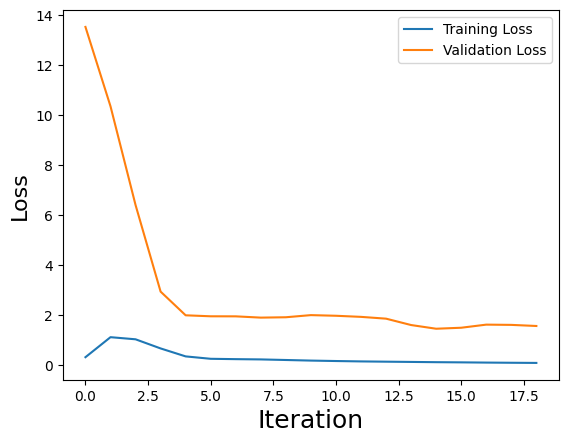

In [ ]:
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.deeplabv3_resnet101()

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False
     
model.classifier = torch.nn.Sequential(
    torch.nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(256, 13, kernel_size=1, stride=1)
)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_trained = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deep_lab=True)

In [ ]:
dice_score_dataset(deeplabV3_trained, test_dataloader, n_classes, is_deep_lab=True)

0.625080782971704

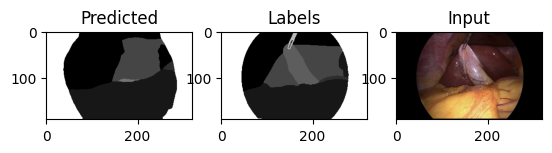

Test loss: 0.613797


0.6137971570216959

In [ ]:
test_eval(test_dataloader, deeplabV3_trained, loss, is_deep_lab=True)

In [ ]:
torch.save(deeplabV3_trained, data_dir + "saved_models/models/deeplabV3_trained_rand_seed.pt")

# EXPERIMENT 2 TRANSFER LEARNING USING A SPECIFIC MODEL

## DeepLabV3

### Restart Runtime

In [ ]:
torch.cuda.empty_cache()

### Training

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start Training...
epoch      train loss           val loss             es_counter(/5)  min-val-loss    time(s)        
0          0.317230             4.936751             0               4.936751        1.432544       
2          0.310756             2.468338             0               2.468338        4.122761       
4          0.252367             2.131103             0               2.131103        6.952151       
6          0.192714             2.106437             1               2.079355        9.737044       
8          0.174045             2.119217             3               2.079355        12.508077      
10         0.145072             1.766687             0               1.766687        15.154381      
12         0.124490             1.708808             1               1.648783        17.996703      
14         0.105064             2.057605             3               1.648783        20.770141      
Stopping Early..

EPOCH 17 of 50
 Train Loss: 0.09369919245538229 Validat

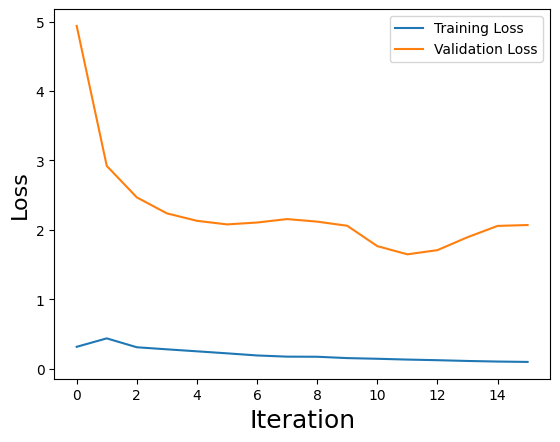

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_transfer = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deep_lab=True)

In [ ]:
dice_score_dataset(deeplabV3_transfer, test_dataloader, n_classes, is_deep_lab=True)

0.6343276888714272

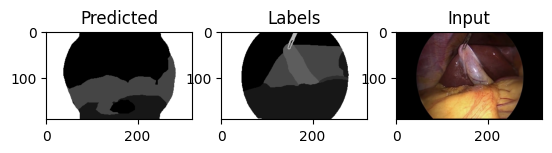

Test loss: 1.019582


1.019581890869666

In [ ]:
test_eval(test_dataloader, deeplabV3_transfer, loss, is_deep_lab=True)

In [ ]:
torch.save(deeplabV3_transfer, data_dir + "saved_models/models/deeplabV3_transfer_rand_seed.pt")

# Experiment 3: Recolorization


## UNet

### Restart Runtime

In [ ]:
torch.cuda.empty_cache()

### Redefine UNet to match Recolorization Module

In [ ]:
## Redefine UNET as in recolorization module
class UNET(nn.Module):

  def __init__(self, n_classes, useBN=True):
    super(UNET, self).__init__()
    # Downgrade Stages
    self.conv1 = add_conv_stage(dim_in=3, dim_out=32, useBN=useBN)
    self.conv2 = add_conv_stage(dim_in=32, dim_out=64, useBN=useBN)
    self.conv3 = add_conv_stage(dim_in=64, dim_out=128, useBN=useBN)
    self.conv4 = add_conv_stage(dim_in=128, dim_out=256, useBN=useBN)

    # Upgrade Stages
    self.conv3m = add_conv_stage(dim_in=256, dim_out=128, useBN=useBN)
    self.conv2m = add_conv_stage(dim_in=128, dim_out=64, useBN=useBN)
    self.conv1m = add_conv_stage(dim_in=64, dim_out=32, useBN=useBN)

    # Maxpool
    self.max_pool = nn.MaxPool2d(kernel_size=2)

    # Upsample Layers
    self.upsample43 = upsample(ch_coarse=256, ch_fine=128)
    self.upsample32 = upsample(ch_coarse=128, ch_fine=64)
    self.upsample21 = upsample(ch_coarse=64, ch_fine=32)

    # Final Layer
    self.conv1x1 = add_conv_stage(dim_in=32, dim_out=n_classes, kernel_size=1, padding=0, useBN=useBN)

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), dim=1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), dim=1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), dim=1)
    conv1m_out = self.conv1m(conv2m_out_)

    conv_out = self.conv1x1(conv1m_out)

    return conv_out

### Training

Also freeze layers except for last

Start Training...
epoch      train loss           val loss             es_counter(/5)  min-val-loss    time(s)        
0          0.307585             2.460284             0               2.460284        1.164469       
2          0.301578             2.440528             0               2.440528        3.740757       
4          0.298509             2.417628             0               2.417628        6.591122       
6          0.294427             2.393328             0               2.393328        8.997152       
8          0.291570             2.380664             0               2.380664        11.539473      
10         0.289927             2.371380             0               2.371380        13.882840      
12         0.288433             2.362670             0               2.362670        16.185259      
14         0.286990             2.354298             0               2.354298        18.719706      
16         0.285588             2.346198             0               2.34

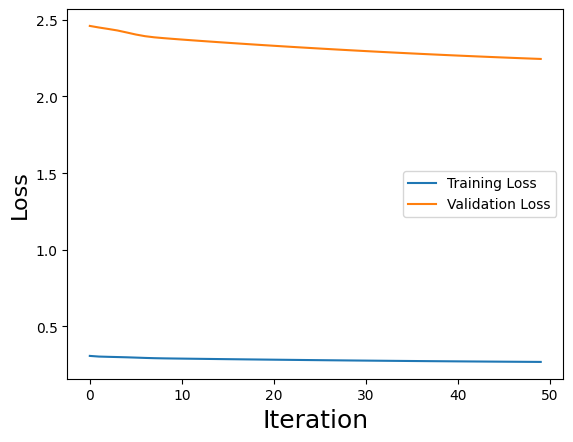

In [ ]:
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-2

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13

# AIDAN'S GOOGLE DRIVE PATH
pre_recolor_unet_model = torch.load(data_dir + 'saved_models/models/unet_recolorization.pt')

# freezing all but last layers
for param in pre_recolor_unet_model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
pre_recolor_unet_model.conv1x1 = nn.Sequential(
    nn.Conv2d(32, n_classes, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

pre_recolor_unet_model = pre_recolor_unet_model.to(device)

optimizer = torch.optim.Adam(pre_recolor_unet_model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_recolored_segmentation = train(pre_recolor_unet_model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs)

In [ ]:
dice_score_dataset(unet_recolored_segmentation, test_dataloader, n_classes)

0.6159707161646009

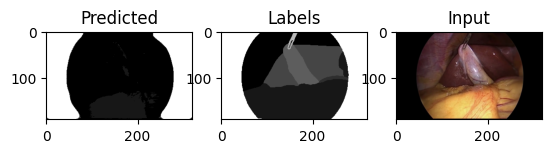

Test loss: 2.032827


2.032827289070992

In [ ]:
test_eval(test_dataloader, unet_recolored_segmentation, loss)

In [ ]:
torch.save(unet_recolored_segmentation, data_dir + "saved_models/models/unet_recolored_segmentation_rand_seed.pt")

## DeepLabV3

### Restart Runtime

In [ ]:
torch.cuda.empty_cache()

### Training

Freeze all except final layer

Start Training...
epoch      train loss           val loss             es_counter(/5)  min-val-loss    time(s)        
0          0.489897             23.756441            0               23.756441       1.377269       
2          29.368659            16.053471            1               12.678554       4.072448       
4          16.766661            7.521297             0               7.521297        6.800502       
6          4.130907             3.077191             0               3.077191        9.400743       
8          0.674982             2.323436             0               2.323436        12.201081      
10         0.233660             2.256802             0               2.256802        14.991987      
12         0.208020             1.839929             0               1.839929        18.048590      
14         0.199841             1.739903             0               1.739903        20.847925      
16         0.170491             1.815162             2               1.73

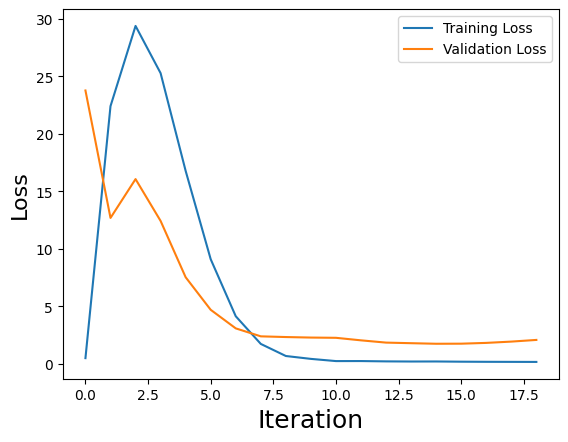

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torch.load(data_dir + 'saved_models/models/deep_lab_recolorization.pt')

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_recolored_segmentation = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deep_lab=True)

In [ ]:
dice_score_dataset(deeplabV3_recolored_segmentation, test_dataloader, n_classes, is_deep_lab=True)

0.5355336071667693

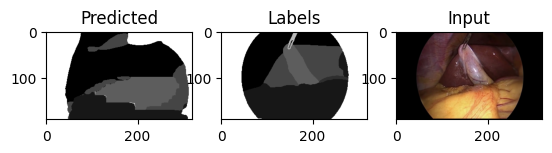

Test loss: 1.618806


1.618806291990794

In [ ]:
test_eval(test_dataloader, deeplabV3_recolored_segmentation, loss, is_deep_lab=True)

In [ ]:
torch.save(deeplabV3_recolored_segmentation, data_dir + "saved_models/models/deeplabV3_recolored_segmentation_rand_seed.pt")

# EXPERIMENT 4:DATA AUGMENTATION

## Apply Data Augmentation

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1

img_transforms_aug = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(), 
  transforms.RandomVerticalFlip(),
  transforms.Resize(size=(192, 320)),
])

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320)),
])

######


train_dataset = ImageDataset(data=train_datapoints, mask_json=mask_json, transforms=img_transforms_aug)
val_dataset = ImageDataset(data=val_datapoints, mask_json=mask_json, transforms=img_transforms)
test_dataset = ImageDataset(data=test_datapoints, mask_json=mask_json, transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), 600)
val_mask = random.sample(range(val_dataset.__len__()), 100)
test_mask = random.sample(range(test_dataset.__len__()), 100)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

20
4
100


## UNet

### Restart Runtime

In [ ]:
torch.cuda.empty_cache()

Start Training...
epoch      train loss           val loss             es_counter(/5)  min-val-loss    time(s)        


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0          0.075879             0.077212             0               0.077212        303.000528     
2          0.065277             0.068165             0               0.068165        499.524894     
4          0.061674             0.065814             0               0.065814        697.836021     
6          0.060206             0.063429             0               0.063429        895.889883     
8          0.058165             0.060058             0               0.060058        1090.859811    
10         0.057089             0.060740             2               0.060058        1289.411317    
12         0.055965             0.058715             0               0.058715        1491.854096    
14         0.054719             0.055501             0               0.055501        1696.289680    
16         0.054437             0.056734             2               0.055501        1890.810043    
18         0.053503             0.055357             1               0.054402        2100.2

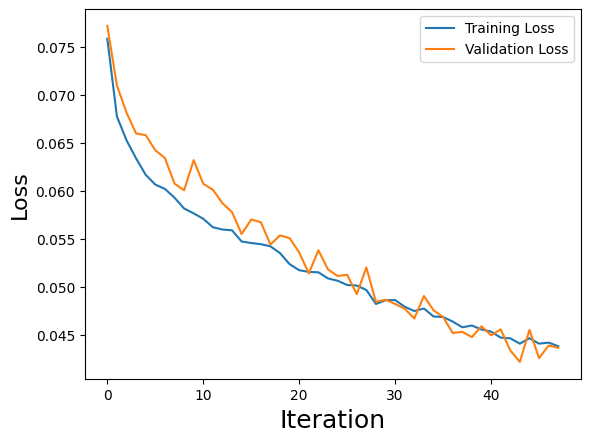

In [ ]:
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50 #Change to 200 later

## Setting up the model, optimizer, and loss function
n_classes = 13
model = UNET(n_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_data_aug = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs)

In [ ]:
dice_score_dataset(unet_data_aug, test_dataloader, n_classes)

0.6972409750941726

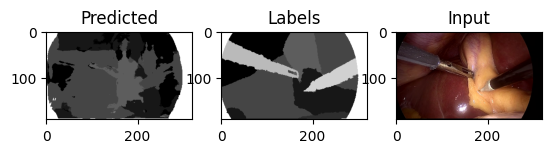

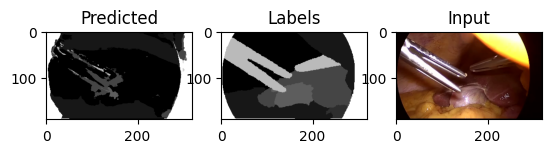

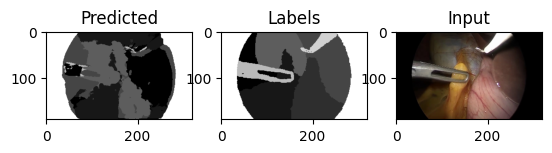

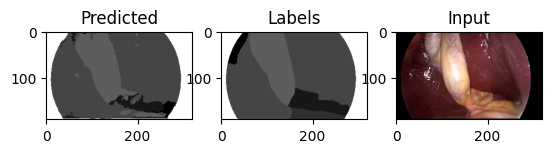

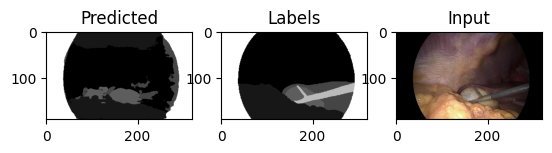

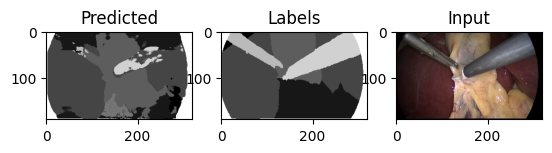

Test loss: 1.031424


1.0314241499546843

In [53]:
test_eval(test_dataloader, unet_data_aug, loss)

In [54]:
torch.save(unet_data_aug, data_dir + "saved_models/models/unet_data_aug_rand_seed.pt")

## DeepLabV3

### Restart Runtime

In [ ]:
torch.cuda.empty_cache()

### Training

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_transfer_aug = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deep_lab=True)

In [ ]:
dice_score_dataset(deeplabV3_transfer_aug, test_dataloader, n_classes, is_deep_lab=True)

In [ ]:
torch.save(deeplabV3_transfer_aug, data_dir + "saved_models/models/deeplabV3_transfer_aug_rand_seed.pt")

In [ ]:
test_eval(test_dataloader, deeplabV3_transfer_aug, loss, is_deep_lab=True)